In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.io
from scipy import stats
from sklearn import decomposition
from lmfit import Model, Parameters

In [5]:
path = Path.home()/'code'/'2023_CENTURI-SummerSchool'/'datasets'/'dataset1_reaching-task'/'Dataset1.mat'
data = scipy.io.loadmat(path)
R = data['R']
direction = data['direction']

In [6]:
print(R.shape) # 143 neurons x 158 trials
print(direction.shape) # 1-8

(143, 158)
(158, 1)


In [7]:
R_mean = R.mean(axis=1)

Text(0, 0.5, 'firing rate of neuron 0')

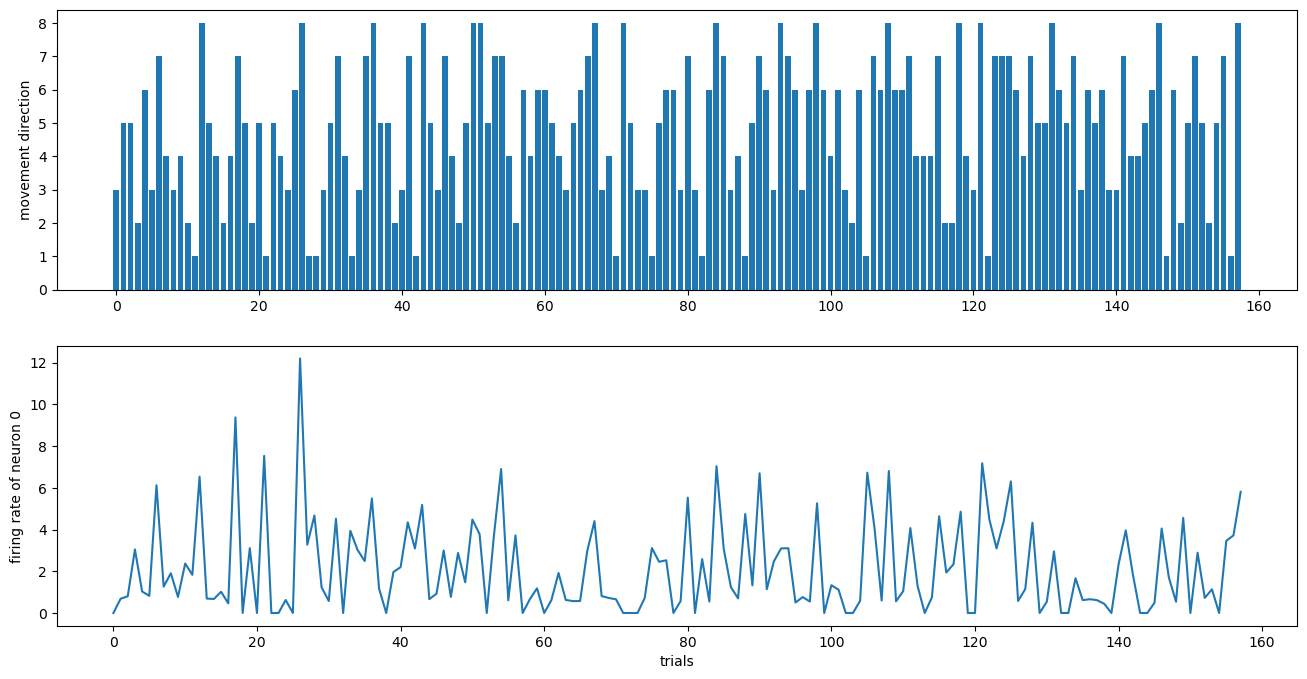

In [8]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(16,8))

ax[0].bar(range(158),direction[:,0])
ax[0].set_ylabel('movement direction')

ax[1].plot(R[0,:])
ax[1].set_xlabel('trials')
ax[1].set_ylabel('firing rate of neuron 0')

In [9]:
for dir_val in range(1,9):
    indices = np.where(direction[:,0]==dir_val)[0]
    print(f'{direction[indices,0].shape[0]} trials for direction {dir_val}')

14 trials for direction 1
12 trials for direction 2
22 trials for direction 3
20 trials for direction 4
25 trials for direction 5
24 trials for direction 6
24 trials for direction 7
17 trials for direction 8


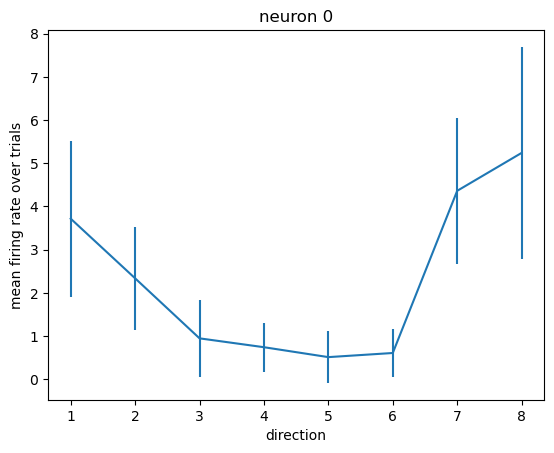

In [10]:
# Mean firing rate for neuron 0 along all directions
mean_dir_FR = []
std_dir_FR = []

for dir_val in range(1,9):
    indices = np.where(direction[:,0]==dir_val)[0]
    mean_dir_FR.append(R[0,indices].mean())
    std_dir_FR.append(R[0,indices].std())
plt.errorbar(range(8),mean_dir_FR,yerr=std_dir_FR)
plt.xticks(ticks=range(8),labels=range(1,9))
plt.title('neuron 0')
plt.ylabel('mean firing rate over trials')
plt.xlabel('direction')
plt.show()

In [11]:
def bootstrapping(firing_rates,num_iterations=1000):
    # Perform bootstrapping
    bootstrapped_means = []
    for _ in range(num_iterations):
        resample = np.random.choice(firing_rates, size=len(firing_rates), replace=True)
        bootstrapped_mean = np.mean(resample)
        bootstrapped_means.append(bootstrapped_mean)
    # return np.std(bootstrapped_means)
    return np.quantile(bootstrapped_means,q=[0.05,0.95])

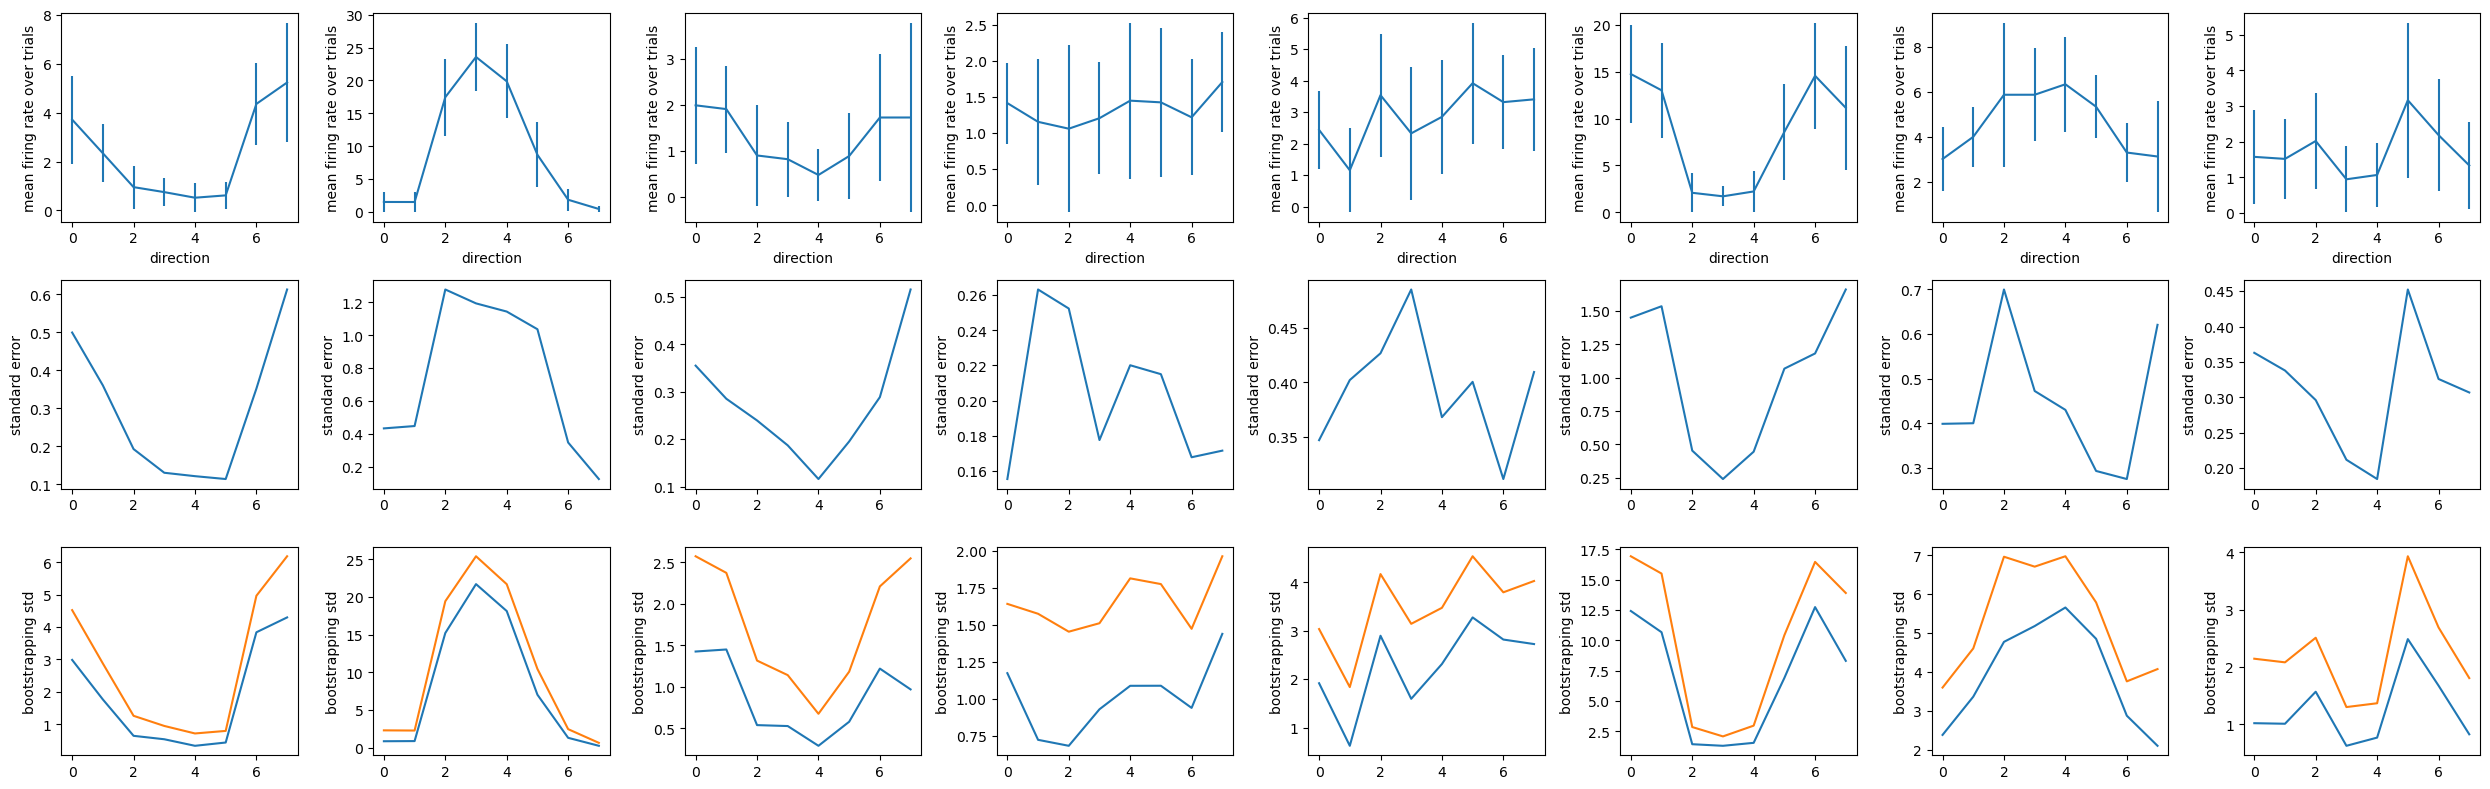

In [12]:
# Mean firing rate for all neuron along all directions
fig, ax = plt.subplots(nrows=3,ncols=8,figsize=(25,8))
for i in range(8):
    mean_dir_FR = []
    std_dir_FR = []
    standard_errors_per_trial = []
    bootstrapping_stds_per_trial = []
    for dir_val in range(1,9):
        indices = np.where(direction[:,0]==dir_val)[0]
        mean_dir_FR.append(R[i,indices].mean())
        std_dir_FR.append(R[i,indices].std())
        standard_errors_per_trial.append(stats.sem(R[i,indices])) # Calculating standard error
        bootstrapping_stds_per_trial.append(bootstrapping(R[i,indices]))
        
    ax[0][i].errorbar(range(8),mean_dir_FR,yerr=std_dir_FR)
    ax[0][i].set_ylabel('mean firing rate over trials')
    ax[0][i].set_xlabel('direction')
    
    ax[1][i].plot(standard_errors_per_trial)
    ax[1][i].set_ylabel('standard error')
    
    ax[2][i].plot(bootstrapping_stds_per_trial)
    ax[2][i].set_ylabel('bootstrapping std')
plt.tight_layout()

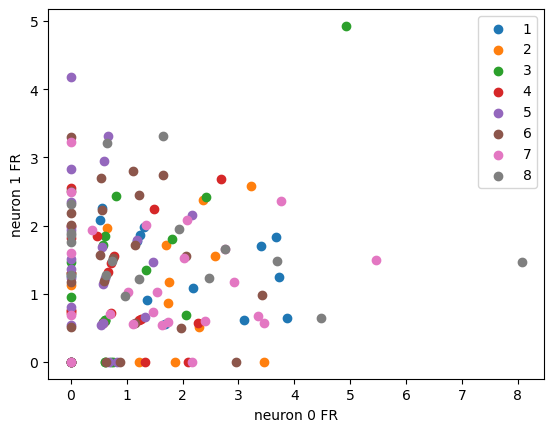

In [13]:
for dir_val in range(1,9):
    indices = np.where(direction[:,0]==dir_val)[0]
    plt.scatter(R[2,indices],R[3,indices])
plt.xlabel('neuron 0 FR')
plt.ylabel('neuron 1 FR')
plt.legend(range(1,9))

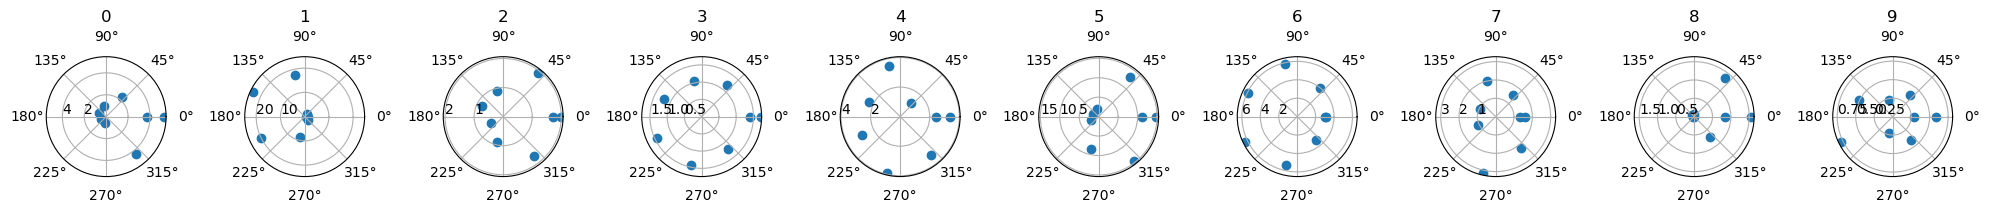

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=10,subplot_kw={'projection': 'polar'},figsize=(20,8))

for i in range(10):
    mean_dir_FR = []
    for dir_val in range(1,9):
        indices = np.where(direction[:,0]==dir_val)[0]
        mean_dir_FR.append(R[i,indices].mean())

    # angles = np.arange(8)
    angles = np.linspace(0, 2 * np.pi, 8)
    responses = np.cos(2 * angles)

    ax[i].scatter(angles, mean_dir_FR)

    # ax.set_rticks([-1, 0, 1])  # Set radial ticks
    ax[i].set_rlabel_position(180)  # Label position along radial axes
    ax[i].grid(True)  # Add a grid

    ax[i].set_title(i)
plt.tight_layout()
plt.show()

In [104]:
# https://gist.github.com/laurentperrinet/de76f53fcb0820844fbf0317ed832035

# https://en.wikipedia.org/wiki/Von_Mises_distribution
def tuning_function(theta, theta0, kappa, fmax, bsl, theta_bound):
    # Von Mises, with kappa the concentration, theta0 the location
    # fmax the firing rate at pref ori, bsl the min firing rate (not the baseline, which was substracted) 
    tf = bsl + np.exp(kappa*(np.cos(2*np.pi/theta_bound*(theta-theta0))-1)) * (fmax-bsl)
    return tf

def fit_tc(array, init_kappa, theta_bound=2*np.pi):
    """
    Fits the data points in `array` to `tuning_function`.
    
    set theta_bound to 2*np.pi for fitting signed angles (eg dirrection)
    or to np.pi for an unsigned one (like orientation)
    """
              
    theta = np.linspace(0, theta_bound, len(array), endpoint=False)
    mod = Model(tuning_function)
    pars = Parameters()
    #               name    default           vary  min   max
    pars.add_many(('theta0', theta[np.argmax(array)], True, 0., theta_bound),
                  ('kappa', init_kappa, True,  .1, 5.),
                  ('fmax', np.max(array), True, 0.0, 2*np.max(array)+5),
                  ('bsl', np.min(array), True, 0.0, np.max(array)+5),
                  ('theta_bound', theta_bound, False))
                
    out = mod.fit(array, pars, theta=theta, nan_policy='omit', max_nfev=50000)

    return out.best_values

neuron 0 theta0 = 7.073467025909311 kappa (precision) = 1.1592409749819639
neuron 1 theta0 = 3.1896287448273086 kappa (precision) = 1.4321957343331357
neuron 2 theta0 = 2.3575363883310274e-10 kappa (precision) = 0.5440013441522494
neuron 3 theta0 = 7.209984853266765 kappa (precision) = 4.999999957986447
neuron 4 theta0 = 5.433090345132782 kappa (precision) = 0.6564066688926512
neuron 5 theta0 = 7.274012210985772 kappa (precision) = 0.6913961736077676
neuron 6 theta0 = 3.349614961081996 kappa (precision) = 0.384590711368193
neuron 7 theta0 = 5.286477554882087 kappa (precision) = 4.999999993285547
neuron 8 theta0 = 0.0918167824786611 kappa (precision) = 1.5338372102129274
neuron 9 theta0 = 3.741582318365316 kappa (precision) = 4.9999999993270325


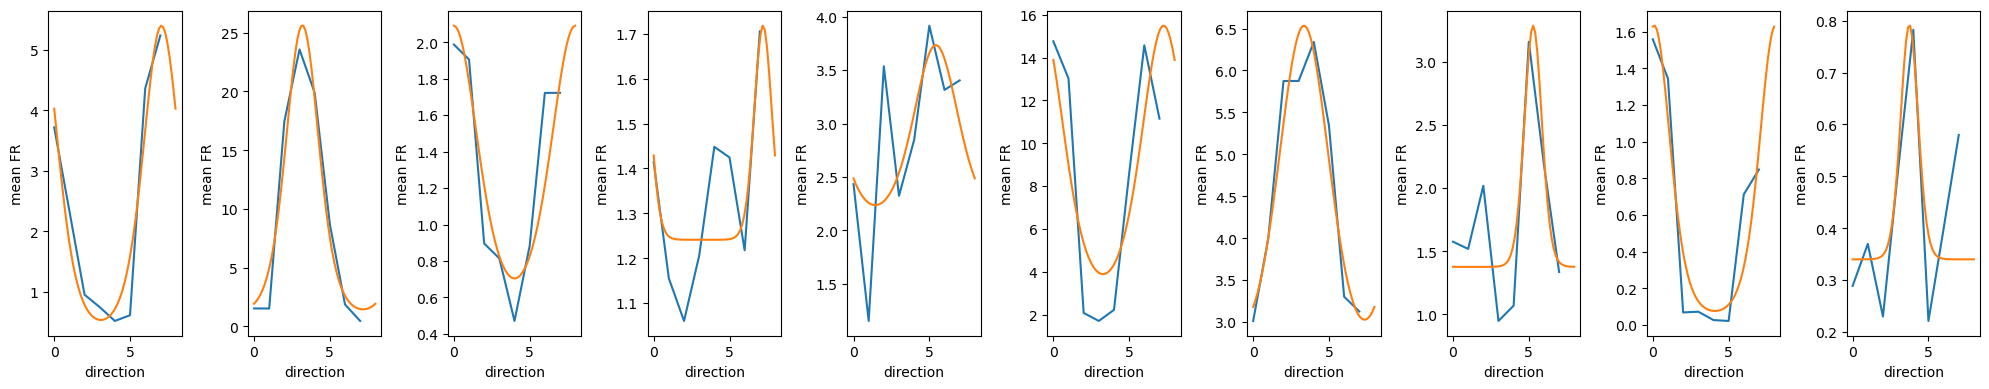

In [105]:
fig, ax = plt.subplots(nrows=1,ncols=10,figsize=(20, 4))

for i in range(10):
    mean_dir_FR = []
    for dir_val in range(1,9):
        indices = np.where(direction[:,0]==dir_val)[0]
        mean_dir_FR.append(R[i,indices].mean())
    fitted_params = fit_tc(np.array(mean_dir_FR), 3.5,theta_bound=8)
    print(f"neuron {i} theta0 = {fitted_params['theta0']} kappa (precision) = {fitted_params['kappa']}")
    theta_more = np.linspace(0, 8, 60, endpoint=True)
    ax[i].plot(mean_dir_FR)
    tf = tuning_function(theta_more, **fitted_params)
    ax[i].plot(theta_more, tf)
    ax[i].set_xlabel('direction')
    ax[i].set_ylabel('mean FR')
plt.tight_layout()

[3, 7, 9, 11, 12, 13, 14, 18, 19, 28, 30, 35, 37, 38, 42, 43, 44, 45, 47, 50, 51, 52, 53, 57, 58, 59, 60, 61, 65, 67, 68, 71, 73, 78, 79, 82, 84, 86, 97, 98, 99, 105, 109, 115, 116, 122, 125, 129, 132, 136, 140, 141]


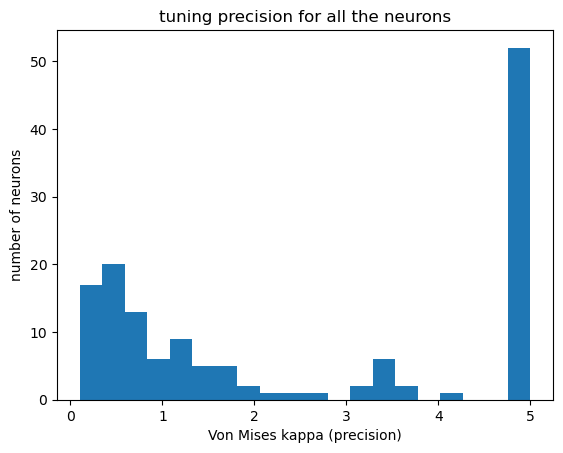

In [113]:
# Checking the tuning precision for all the neurons

high_kappa_neuron_ids = []
kappa_threshold = 4.5

kappas = []
theta0s = []

for i in range(R.shape[0]):
    mean_dir_FR = []
    for dir_val in range(1,9):
        indices = np.where(direction[:,0]==dir_val)[0]
        mean_dir_FR.append(R[i,indices].mean())
    fitted_params = fit_tc(np.array(mean_dir_FR), 3.5,theta_bound=8)
    kappas.append(fitted_params['kappa'])
    theta0s.append(fitted_params['theta0'])
    # print(f"neuron {i} theta0 = {fitted_params['theta0']} kappa (precision) = {fitted_params['kappa']}")
    if fitted_params['kappa'] >= kappa_threshold: high_kappa_neuron_ids.append(i)
plt.hist(kappas,bins=20)
plt.title('tuning precision for all the neurons')
plt.xlabel('Von Mises kappa (precision)')
plt.ylabel('number of neurons')

print(high_kappa_neuron_ids)

In [107]:
max_inds = np.argsort(np.array(kappas)[high_kappa_neuron_ids])
max_real_inds = np.array(high_kappa_neuron_ids)[max_inds]
max_five_inds = np.flip(max_real_inds[-5:])
max_five_inds

array([141,  82,  47,  13,  37])

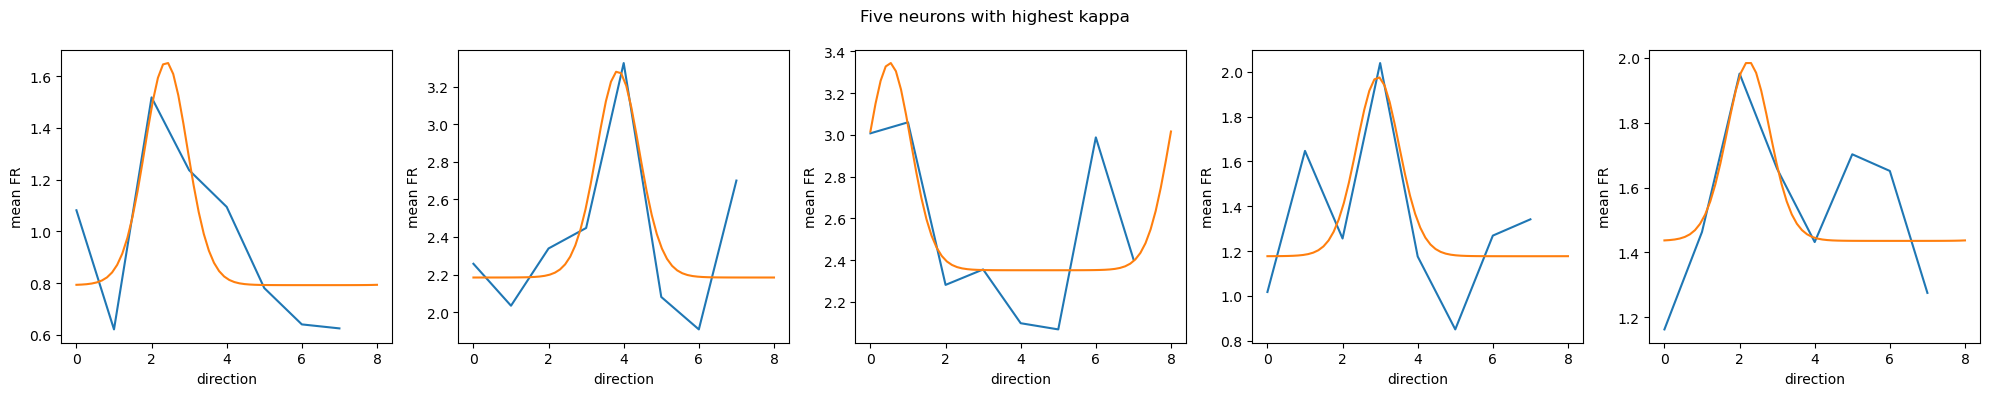

In [108]:
fig, ax = plt.subplots(nrows=1,ncols=5,figsize=(20, 4))

for i in range(5):
    mean_dir_FR = []
    for dir_val in range(1,9):
        indices = np.where(direction[:,0]==dir_val)[0]
        mean_dir_FR.append(R[max_five_inds[i],indices].mean())
    fitted_params = fit_tc(np.array(mean_dir_FR), 3.5,theta_bound=8)
    theta_more = np.linspace(0, 8, 60, endpoint=True)
    ax[i].plot(mean_dir_FR)
    tf = tuning_function(theta_more, **fitted_params)
    # print(tuning_function(, **fitted_params))
    ax[i].plot(theta_more, tf)
    ax[i].set_xlabel('direction')
    ax[i].set_ylabel('mean FR')
plt.suptitle('Five neurons with highest kappa')
plt.tight_layout()

Text(0, 0.5, 'mean FR')

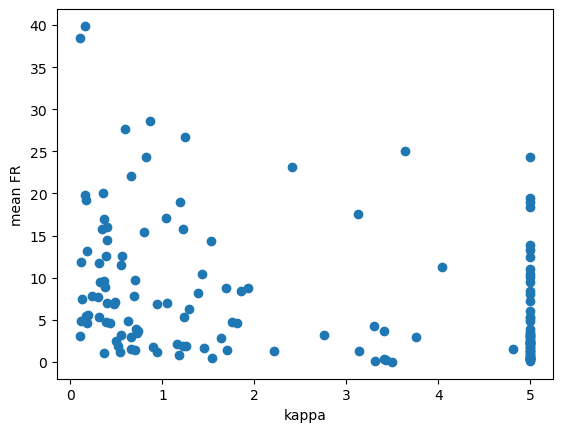

In [109]:
plt.scatter(kappas, R_mean)
plt.xlabel('kappa')
plt.ylabel('mean FR')

Tuning depth = maximum FR - minimum FR

Outliers would have low tuning depth

Text(0, 0.5, 'number of neurons')

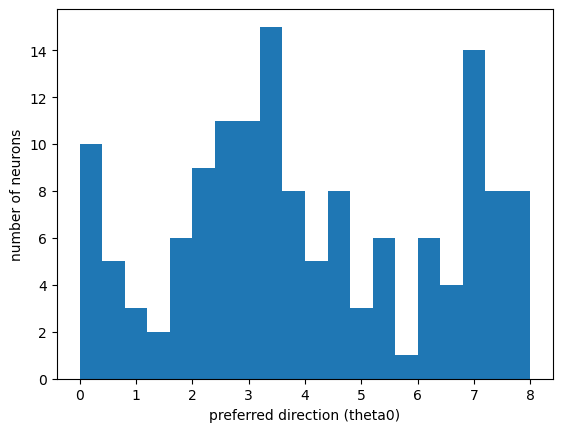

In [117]:
plt.hist(theta0s,bins=20)
plt.xlabel('preferred direction (theta0)')
plt.ylabel('number of neurons')

Text(0, 0.5, 'FR std')

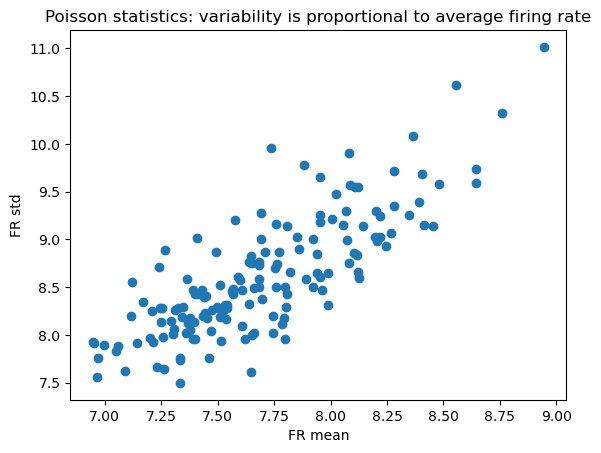

In [110]:
plt.title('Poisson statistics: variability is proportional to average firing rate')
plt.scatter(R.mean(axis=0),R.std(axis=0))
plt.xlabel('FR mean')
plt.ylabel('FR std')